In [10]:
import networkx as nx
%matplotlib inline
import matplotlib.pyplot as plt


# read Facebook Ego Network
# /Volumes/theory/entropy/graphly

g = nx.read_edgelist('../../Datasets/facebook_combined.txt', nodetype=int)
print nx.info(g)



Name: 
Type: Graph
Number of nodes: 4039
Number of edges: 88234
Average degree:  43.6910


In [7]:
from multiprocessing import Pool
import itertools

def partitions(nodes, n):
	"Partitions the nodes into n subsets"
	nodes_iter = iter(nodes)
	while True:
		partition = tuple(itertools.islice(nodes_iter,n))
		if not partition:
			return
		yield partition
        
def btwn_pool(G_tuple):
    return nx.betweenness_centrality_source(*G_tuple)

# To begin the parallel computation, we initialize a Pool object with the
# number of available processors on our hardware. We then partition the
# network based on the size of the Pool object (the size is equal to the 
# number of available processors). 
def between_parallel(G, processes = None):
	p = Pool(processes=processes)
	part_generator = 4*len(p._pool)
	node_partitions = list(partitions(G.nodes(), int(len(G)/part_generator)))
	num_partitions = len(node_partitions)

    #Next, we pass each processor a copy of the entire network and 
    #compute #the betweenness centrality for each vertex assigned to the 
    #processor.

	bet_map = p.map(btwn_pool,
					zip([G]*num_partitions,
						[True]*num_partitions,
						[None]*num_partitions,
						node_partitions))

    #Finally, we collect the betweenness centrality calculations from each 
    #pool and aggregate them together to compute the overall betweenness 
    #centrality score for each vertex in the network.

	bt_c = bet_map[0]
	for bt in bet_map[1:]:
		for n in bt:
			bt_c[n] += bt[n]
	return bt_c

In [8]:
## Parellel Betweeness Centrality
bt = between_parallel(g)
top = 10

max_nodes =  sorted(bt.iteritems(), key = lambda v: -v[1])[:top]


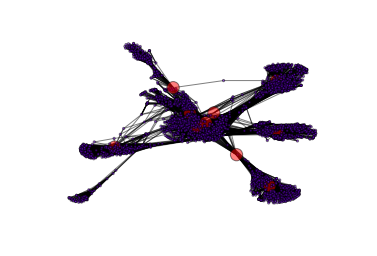

In [13]:
bt_values = [5]*len(g.nodes())
bt_colors = [0]*len(g.nodes())
for max_key, max_val in max_nodes:
    bt_values[max_key] = 150
    bt_colors[max_key] = 2
 
plt.axis("off")
nx.draw_networkx(g, pos = nx.spring_layout(g), cmap = plt.get_cmap("rainbow"), node_color = bt_colors, node_size = bt_values, with_labels = False, alpha=0.5)